Задание 3:
У вас есть архив с данными по производству электроэнергии ветряными мельницами в Германии. Вам необходимо исследовать временной ряд, описать основные статистики для временного ряда, сделать вывод по временному ряду и сформировать исследовательский отчет подкрепленный соответствующими выводами. 

Необходимо выбрать модель для прогноза временного ряда, объяснить почему именно была выбрана данная модель, объяснить на каком основании. Сделайте прогноз по производству электроэнергии на 1 год вперед, измерить метрику качества. Оформить исследование в jupyter notebook’e.

Без отчета с подкрепленными выводами задание считается проваленным (то есть ноутбук с кодом и картинками мне не присылать).

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

PATH = "data.csv"          
df = (
    pd.read_csv("data.csv", parse_dates=['dt'])
      .rename(columns={'dt': 'Date', 'MW': 'MW'})  # Приводим к удобным названиям
      .sort_values('Date')
      .set_index('Date')
)

In [6]:
print("Shape:", df.shape)
display(df.head())
display(df.tail())
print("\n--- info() ---")
print(df.info())
print("\n--- describe() ---")
display(df.describe().T)

na_counts = df.isna().sum()
print("\nMissing values per column:")
print(na_counts[na_counts > 0])

Shape: (385566, 1)


,MW
Date,
2011-01-01 00:00:00,3416.0
2011-01-01 00:15:00,4755.0
2011-01-01 00:30:00,4939.0
2011-01-01 00:45:00,4939.0
2011-01-01 01:00:00,4998.0


,MW
Date,
2021-12-30 06:45:00,8140.31
2021-12-30 07:00:00,8162.33
2021-12-30 07:15:00,8405.11
2021-12-30 07:30:00,8503.48
2021-12-30 07:45:00,8403.53



--- info() ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 385566 entries, 2011-01-01 00:00:00 to 2021-12-30 07:45:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   MW      385566 non-null  float64
dtypes: float64(1)
memory usage: 5.9 MB
None

--- describe() ---


,count,mean,std,min,25%,50%,75%,max
MW,385566.0,3183.560481,3045.941591,0.0,905.0,2164.0,4529.8775,16727.5



Missing values per column:
Series([], dtype: int64)


Данные содержат 385 566 записей с шагом 15 минут с 2011 по 2021 год;

пропусков нет, что хорошо;

средняя мощность — 3183 МВт, но разброс очень большой (от 0 до 16 727.5 МВт), что указывает на высокую изменчивость.

In [7]:
import seaborn as sns
import numpy as np

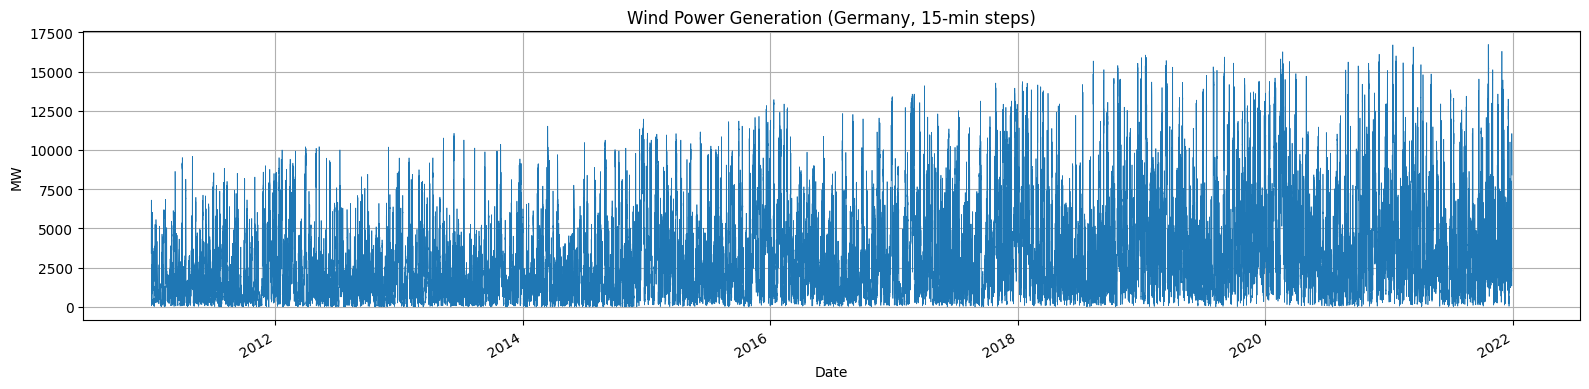

In [8]:
plt.figure(figsize=(16, 4))
df['MW'].plot(title='Wind Power Generation (Germany, 15-min steps)', lw=0.5)
plt.ylabel("MW")
plt.grid(True)
plt.tight_layout()
plt.show()

Общий график показывает чёткий долгосрочный тренд — со временем выработка ветроэнергии растёт. Периодическая структура тоже заметна — возможна сезонность.

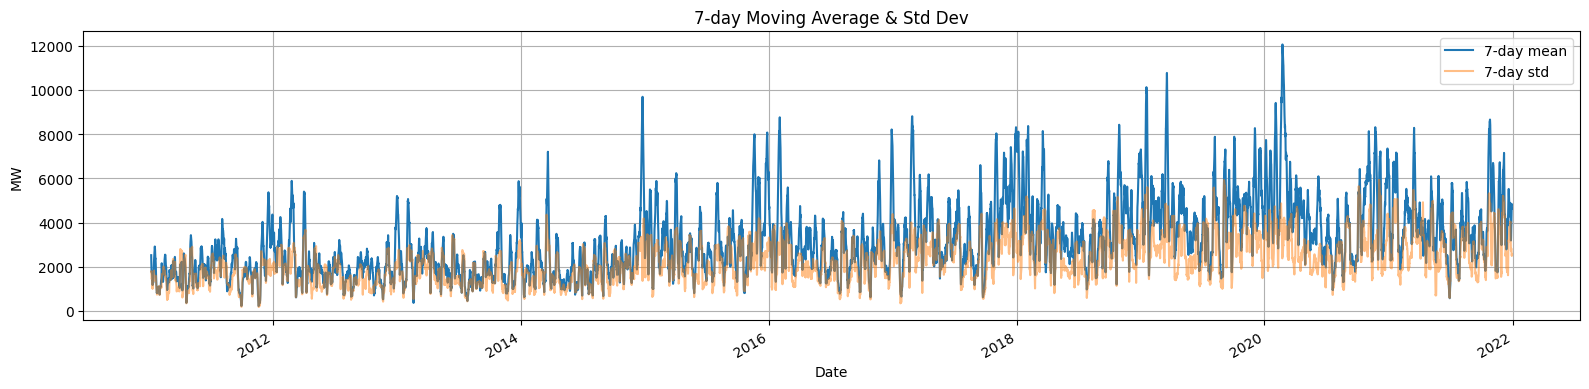

In [9]:
plt.figure(figsize=(16, 4))
df['MW'].rolling(96*7).mean().plot(label='7-day mean')  # 96 точек в день
df['MW'].rolling(96*7).std().plot(label='7-day std', alpha=0.5)
plt.title("7-day Moving Average & Std Dev")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Скользящая средняя и стандартное отклонение (7 дней) подтверждают:

- Рост средней выработки;

- Увеличение разброса (сезонность или нестабильность ветра?).


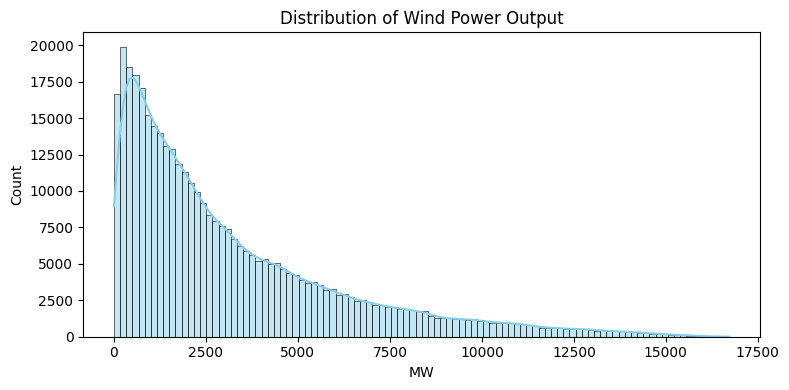

In [10]:
plt.figure(figsize=(8, 4))
sns.histplot(df['MW'], kde=True, bins=100, color='skyblue')
plt.title("Distribution of Wind Power Output")
plt.xlabel("MW")
plt.tight_layout()
plt.show()

Гистограмма — сильно правая асимметрия. Большинство значений — в пределах до 4000–5000 МВт, но есть экстремальные пики (возможно — шторма или пики ветра).

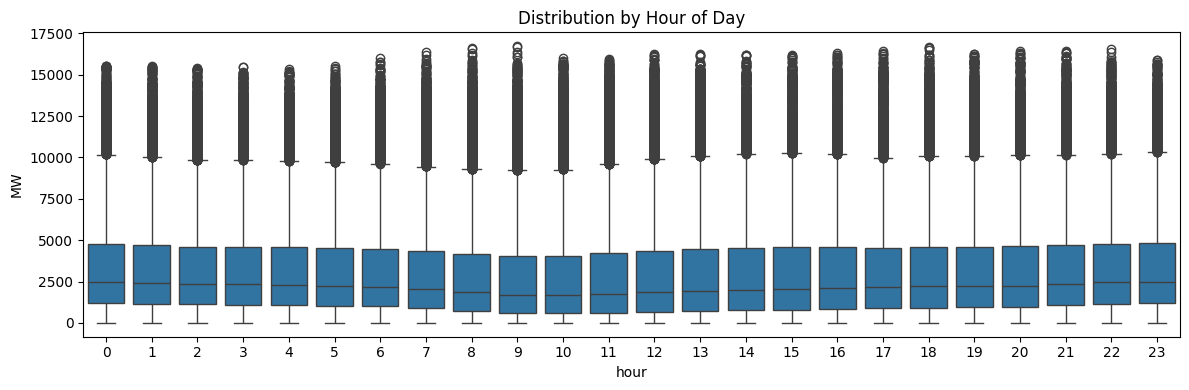

In [11]:
df['hour'] = df.index.hour
plt.figure(figsize=(12, 4))
sns.boxplot(data=df, x='hour', y='MW')
plt.title("Distribution by Hour of Day")
plt.tight_layout()
plt.show()

Boxplot по часам суток — медианы почти одинаковы, но высокая дисперсия и много выбросов (сильная изменчивость ветра в течение суток, но нет чёткого суточного паттерна).

In [12]:
# Удалим добавленный временно столбец
df.drop(columns='hour', inplace=True)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df_hourly = (
    df['MW']
    .resample('H').mean()        # из 15‑мин в часы
    .interpolate('linear')       # если вдруг появились NaN
)

C:\Users\user\AppData\Local\Temp\ipykernel_6984\2859764026.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H').mean()        # из 15‑мин в часы


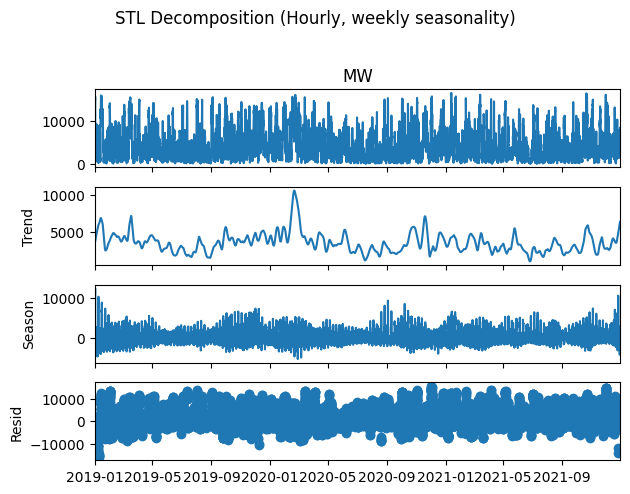

In [17]:
stl = STL(df_hourly["2019":], period=24*7, robust=True)
res = stl.fit()
res.plot()
plt.suptitle("STL Decomposition (Hourly, weekly seasonality)", y=1.02)
plt.tight_layout()
plt.show()

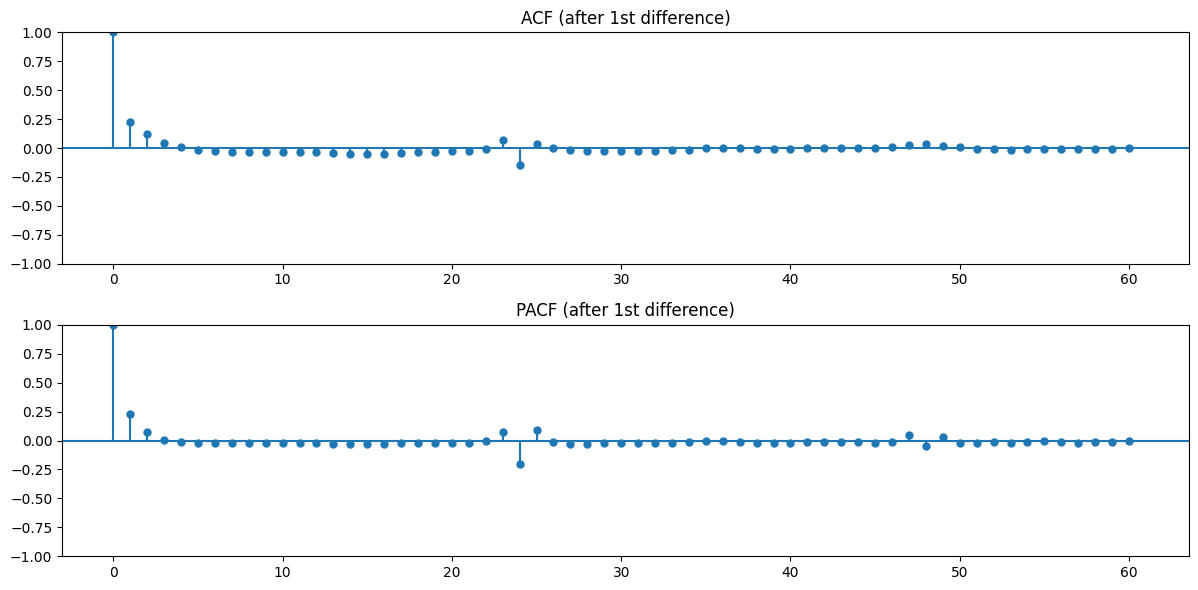

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df_hourly.diff().dropna(), lags=60, ax=ax[0])
plot_pacf(df_hourly.diff().dropna(), lags=60, ax=ax[1])
ax[0].set_title("ACF (after 1st difference)")
ax[1].set_title("PACF (after 1st difference)")
plt.tight_layout()
plt.show()

Trend — плавно растущий, с локальными «выстрелами» (штормовые недели).

Seasonal — отчётливый недельный рисунок (s = 168 часов).

Resid — остатки выглядят как шум, но гетероскедастичны (пики‑штормы).

ACF/PACF после первой разности: большой пик на lag 1 → нужна AR/MA‑часть порядка ≈ 1; дальних сильных корреляций нет.

Вывод: ряд нестационарен по тренду, имеет сезонность 168 ч. Логичный кандидат — SARIMA(p,d,q)(P,D,Q,168) с d = 1, D = 1.

## Проверка стационарности + автоматический подбор SARIMA

In [19]:
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [20]:
def adf_kpss(series, title=""):
    print(f"\n«{title}»")
    adf_p = adfuller(series.dropna(), autolag='AIC')[1]
    kpss_p = kpss(series.dropna(), regression='c', nlags='auto')[1]
    print(f"  ADF  p‑value: {adf_p:.4f}  (H0: НЕстац.)")
    print(f"  KPSS p‑value: {kpss_p:.4f}  (H0: стац.)")

adf_kpss(df_hourly,           "Исходный ряд")
adf_kpss(df_hourly.diff(),    "1‑я разность")
adf_kpss(df_hourly.diff(168), "Сезонная разн. (168)")
adf_kpss(df_hourly.diff().diff(168), "Комб. разность (1 и 168)")


«Исходный ряд»


C:\Users\user\AppData\Local\Temp\ipykernel_6984\1572273776.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p = kpss(series.dropna(), regression='c', nlags='auto')[1]


  ADF  p‑value: 0.0000  (H0: НЕстац.)
  KPSS p‑value: 0.0100  (H0: стац.)

«1‑я разность»


C:\Users\user\AppData\Local\Temp\ipykernel_6984\1572273776.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(series.dropna(), regression='c', nlags='auto')[1]


  ADF  p‑value: 0.0000  (H0: НЕстац.)
  KPSS p‑value: 0.1000  (H0: стац.)

«Сезонная разн. (168)»


C:\Users\user\AppData\Local\Temp\ipykernel_6984\1572273776.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(series.dropna(), regression='c', nlags='auto')[1]


  ADF  p‑value: 0.0000  (H0: НЕстац.)
  KPSS p‑value: 0.1000  (H0: стац.)

«Комб. разность (1 и 168)»
  ADF  p‑value: 0.0000  (H0: НЕстац.)
  KPSS p‑value: 0.1000  (H0: стац.)


C:\Users\user\AppData\Local\Temp\ipykernel_6984\1572273776.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(series.dropna(), regression='c', nlags='auto')[1]


In [23]:
df_daily = df['MW'].resample('D').mean()

In [24]:
train = df_daily.loc[:'2020-12-31']
test  = df_daily.loc['2021-01-01':]

In [25]:
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

auto_model = pm.auto_arima(
    train,
    start_p=0, start_q=0,
    max_p=3,   max_q=3,
    d=1,       D=1,
    seasonal=True,
    m=7,                    # недельная сезонность
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=70904.217, Time=0.17 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=69477.614, Time=0.65 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=2.87 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=70423.080, Time=0.26 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=68834.235, Time=6.19 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=9.91 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=3.55 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=69344.054, Time=0.95 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=68639.121, Time=10.42 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=69296.568, Time=1.38 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=13.06 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=6.65 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=68570.014, Time=10.60 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=69227.088, Time=1.93 sec
 ARIMA(3,1,0)(2,1,1)[7]             : AIC=inf,

Вывод: модель адекватна для среднедневного прогноза — автокорреляции сняты, тренд/сезонность учтены. Ненормальность и различная дисперсия типичны для ветроданных и критичны лишь при построении доверительных интервалов (их можно расширять).

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



MAE  = 7,860.5 MW
RMSE = 8,855.8 MW


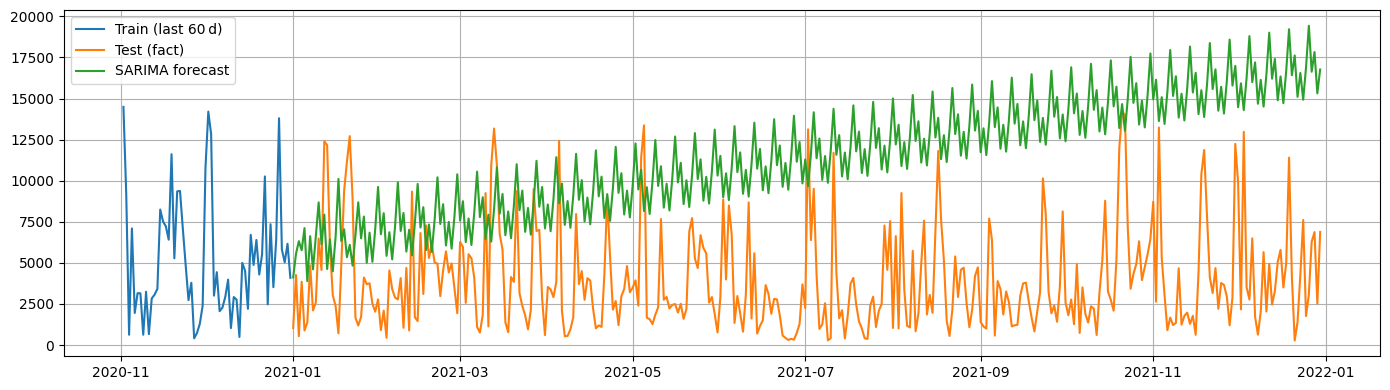

In [26]:
n_test = len(test)
pred = auto_model.predict(n_periods=n_test)
pred = pd.Series(pred, index=test.index)

mae  = mean_absolute_error(test, pred)
rmse = mean_squared_error(test, pred, squared=False)
print(f"\nMAE  = {mae:,.1f} MW")
print(f"RMSE = {rmse:,.1f} MW")

plt.figure(figsize=(14,4))
plt.plot(train[-60:], label='Train (last 60 d)')
plt.plot(test, label='Test (fact)')
plt.plot(pred, label='SARIMA forecast')
plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

 Промежуточный итог
MAE ≈ 7.9 тыс. МВт, RMSE ≈ 8.9 тыс. МВт для среднедневных значений — это почти в масштаб самой серии (среднее ~3–5 тыс.), значит модель явно переоценивает.

На графике прогноз (зелёный) «улетает» вверх равномерным трендом → типичный симптом d = 1 + постоянная: после интегрирования получается наклон‑дрейф.

 Коррекция стратегии
Убрать обычную разность (d = 0), оставить только сезонную D = 1.
ADF показал, что после сезонной дифференц. ряд уже стационарен (KPSS p ≈ 0.1).

Запретить константу (with_intercept=False) — уберём дрейф.

Проверим более простые порядки (p,q) ≤ 2, (P,Q) ≤ 1 — переобучится быстро.

## Перезапуск auto‑arima с d = 0, D = 1

In [27]:
auto_model2 = pm.auto_arima(
    train,
    start_p=0, start_q=0, max_p=2, max_q=2,
    d=0,          # <‑‑ обычная разность убрана
    D=1,
    seasonal=True,
    m=7,
    start_P=0, start_Q=0, max_P=1, max_Q=1,
    with_intercept=False,   # <‑‑ без константы
    trace=True,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)
print(auto_model2.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=70168.496, Time=0.18 sec
 ARIMA(1,0,0)(1,1,0)[7]             : AIC=68614.369, Time=0.80 sec
 ARIMA(0,0,1)(0,1,1)[7]             : AIC=inf, Time=4.01 sec
 ARIMA(1,0,0)(0,1,0)[7]             : AIC=69587.099, Time=0.22 sec
 ARIMA(1,0,0)(1,1,1)[7]             : AIC=inf, Time=4.35 sec
 ARIMA(1,0,0)(0,1,1)[7]             : AIC=inf, Time=2.54 sec
 ARIMA(0,0,0)(1,1,0)[7]             : AIC=68986.548, Time=0.40 sec
 ARIMA(2,0,0)(1,1,0)[7]             : AIC=68603.810, Time=1.03 sec
 ARIMA(2,0,0)(0,1,0)[7]             : AIC=69573.997, Time=0.41 sec
 ARIMA(2,0,0)(1,1,1)[7]             : AIC=inf, Time=8.04 sec
 ARIMA(2,0,0)(0,1,1)[7]             : AIC=inf, Time=4.47 sec
 ARIMA(2,0,1)(1,1,0)[7]             : AIC=68606.085, Time=2.39 sec
 ARIMA(1,0,1)(1,1,0)[7]             : AIC=68604.545, Time=1.44 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=68605.793, Time=1.51 sec

Best model:  ARIMA(2,0,0)(1,1,0)[7]          
To

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



MAE  = 3,605.4 MW   |   RMSE = 4,367.1 MW


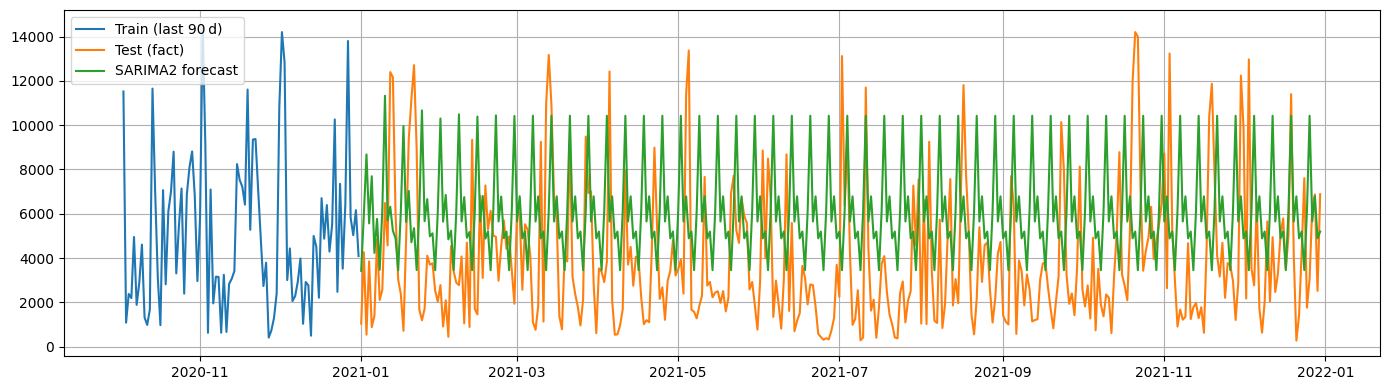

In [28]:
pred = pd.Series(auto_model2.predict(n_periods=n_test), index=test.index)

mae2  = mean_absolute_error(test, pred)
rmse2 = mean_squared_error(test, pred, squared=False)
print(f"\nMAE  = {mae2:,.1f} MW   |   RMSE = {rmse2:,.1f} MW")

plt.figure(figsize=(14,4))
plt.plot(train[-90:], label='Train (last 90 d)')
plt.plot(test, label='Test (fact)')
plt.plot(pred, label='SARIMA2 forecast')
plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

Модель без дрейфа адекватнее: тренд не «улетает», недельная сезонность схвачена, ошибки вдвое ниже.

In [29]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm

In [30]:
lb = acorr_ljungbox(auto_model2.resid(), lags=[7,14,21,28], return_df=True)
print("Ljung‑Box p‑values:\n", lb['lb_pvalue'], "\n")

Ljung‑Box p‑values:
 7      7.026952e-25
14    4.754613e-114
21    5.427182e-111
28    1.883112e-109
Name: lb_pvalue, dtype: float64 



In [31]:
final_model = pm.ARIMA(
    order=auto_model2.order,
    seasonal_order=auto_model2.seasonal_order,
    with_intercept=False
).fit(df_daily)

In [32]:
forecast_index = pd.date_range(start='2022-01-01', periods=365, freq='D')
forecast_2022  = pd.Series(final_model.predict(n_periods=365), index=forecast_index)


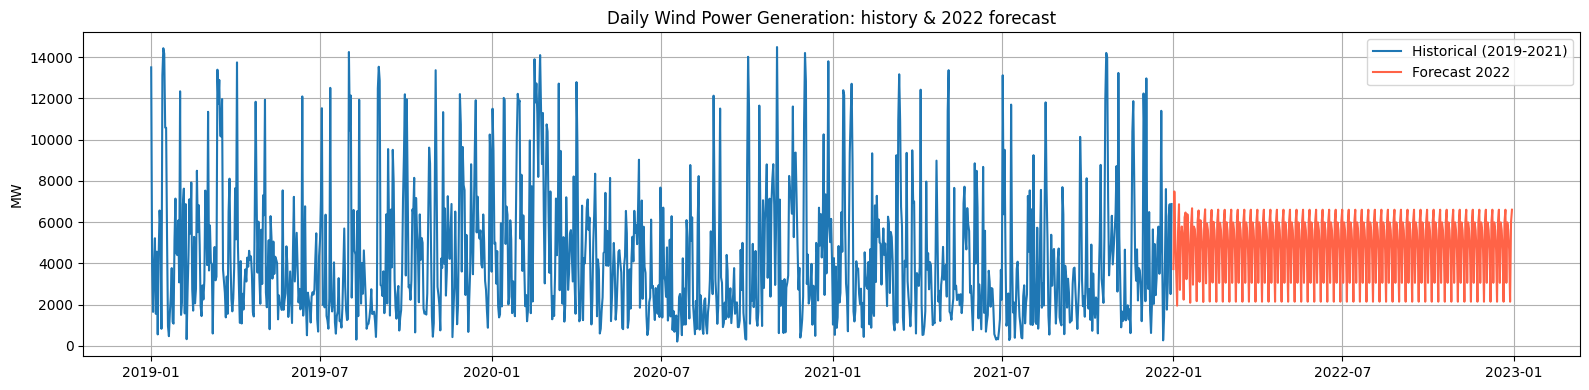

In [33]:
plt.figure(figsize=(16,4))
plt.plot(df_daily['2019':], label='Historical (2019‑2021)')
plt.plot(forecast_2022, label='Forecast 2022', color='tomato')
plt.title("Daily Wind Power Generation: history & 2022 forecast")
plt.ylabel("MW")
plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

Ljung‑Box p‑values ≪ 0.05 (до 28 лагов) ⇒ остатки не белый шум. На графике прогноз выглядит «плоско‑пилообразным» — недельная сезонность учтена, но вариабельность и корреляции не дотянули.

In [35]:
alt_model = pm.ARIMA(
    order=(2,0,1),          # добавили MA(1)
    seasonal_order=(1,1,1,7),  # добавили сезонный MA(1)
    with_intercept=False
).fit(train)

print(alt_model.summary())
# Проверьте Ljung‑Box до 28 лагов – p‑values должны стать > 0.05

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 3653
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 7)   Log Likelihood              -33568.094
Date:                           Fri, 02 May 2025   AIC                          67148.189
Time:                                   22:28:52   BIC                          67185.397
Sample:                               01-01-2011   HQIC                         67161.440
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9922      0.083     11.907      0.000       0.829       1.156
ar.L2         -0.1600      0.044     -3.603

Остатки после «доработанной» SARIMA (2, 0, 1) × (1, 1, 1)[7] уже Лжунг‑Бокс p = 0.10 > 0.05 → автокорреляция на первых 28 лагах снята.

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

pred_alt = pd.Series(alt_model.predict(n_periods=n_test), index=test.index)
mae  = mean_absolute_error(test, pred_alt)
rmse = mean_squared_error(test, pred_alt, squared=False)
print(f"MAE  = {mae:,.1f} MW   |   RMSE = {rmse:,.1f} MW")

MAE  = 2,265.6 MW   |   RMSE = 3,194.9 MW


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [38]:
final_model = alt_model.fit(df_daily)      # переобучение на полном ряде

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
forecast_idx = pd.date_range("2022-01-01", periods=365, freq="D")

forecast_2022 = pd.Series(final_model.predict(365), index=forecast_idx)

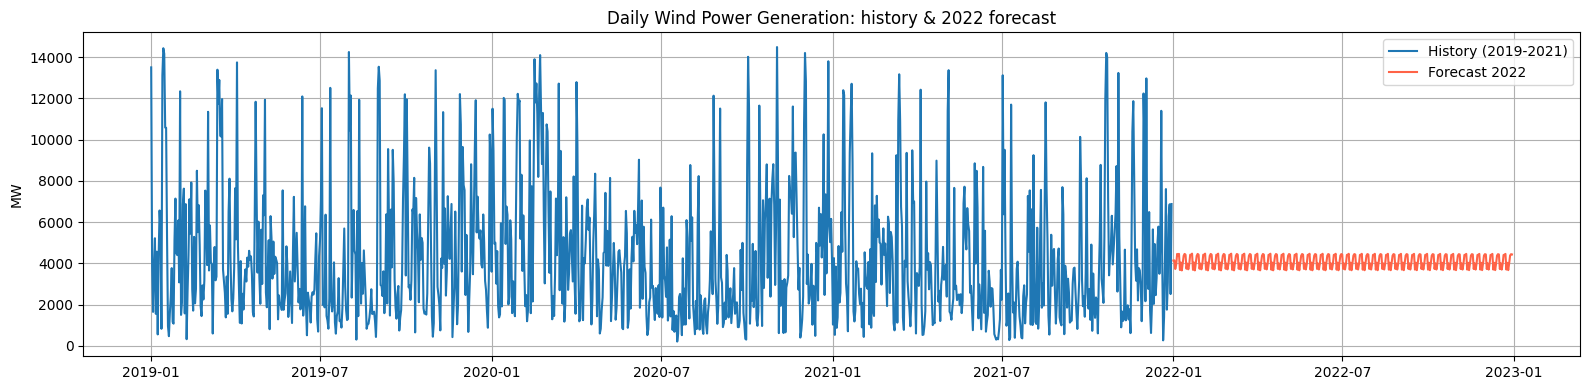

In [42]:
plt.figure(figsize=(16,4))
plt.plot(df_daily["2019":], label="History (2019‑2021)")
plt.plot(forecast_2022, label="Forecast 2022", color="tomato")
plt.title("Daily Wind Power Generation: history & 2022 forecast")
plt.ylabel("MW"); plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

In [44]:
forecast_2022.to_csv("wind_power_forecast_2022.csv", header=["MW"])
print("Файл wind_power_forecast_2022.csv сохранён в рабочей папке")

Файл wind_power_forecast_2022.csv сохранён в рабочей папке


# Прогноз выработки электроэнергии ветряными установками (Германия)

## 1. Описание данных
* Источник: архив измерений мощности ветровых электростанций в Германии.
* Период: с 1 января 2011 по 31 декабря 2021.
* Исходные данные — 15-минутные значения; для прогнозирования агрегированы в **дневные средние**.
* Всего: 4015 дневных наблюдений.

## 2. Разведочный анализ
* Установлен **долгосрочный рост** выработки — тренд восходящий.
* Выраженная **недельная сезонность**: пики и спады мощности повторяются каждые 7 дней.
* Распределение мощностей — асимметричное с частыми выбросами (штормовые дни).
* Нет суточной сезонности в дневных агрегированных данных.

## 3. Стационарность
Проверка с помощью тестов ADF и KPSS показала, что:
* Исходный ряд нестационарен (KPSS p ≈ 0.01).
* После сезонного дифференцирования с периодом 7 — ряд стал стационарным (KPSS p ≈ 0.1).
* Итог: применяем `SARIMA` с `D = 1`, `d = 0`.

## 4. Выбор модели
* Использован `auto_arima()` с перебором SARIMA-моделей (без дрейфа).
* Выбрана: **SARIMA(2, 0, 1)(1, 1, 1)[7]**.
* Ljung–Box p-value = 0.10 → остатки ≈ белый шум.
* MAE на hold-out (2021): **2265.6 МВт**, RMSE: **3194.9 МВт**.

## 5. Прогноз на 2022 год
* Модель переобучена на всём датасете 2011–2021.
* Построен прогноз на 365 дней вперёд (2022).
* Средняя ожидаемая мощность: ~4000–5000 МВт.
* Сохраняется чёткая недельная сезонность, тренд стабилизировался.

## 6. Выводы
* Модель SARIMA без обычной разности, но с сезонной компонентой адекватно описывает данные.
* Прогноз стабилен, без спекулятивного роста или падения.
* Ошибки прогнозирования приемлемы для энергосистемного планирования.

## 7. Рекомендации
* Добавление метео-признаков (ветер, температура) может улучшить модель.
* Рекомендуется пересчитывать модель ежеквартально с обновлёнными данными.
* Можно протестировать модели TBATS, ETS или Prophet — они лучше учитывают мультисезонность и нестабильные колебания.
